<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3-revised

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

## Exploratory Data Analysis

In [3]:
# Check out the shape
house.shape

(1460, 81)

In [4]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

#### RH=Residential High Density, RL=Residential Low Density, RP=Residential Low Density Park, RM=Residential Medium Density.

In [5]:
# Remove non-residential houses
print house.MSZoning.value_counts(dropna=False)
house = house[house.MSZoning.isin(['RL','RM','RP','RH'])]
print house.shape

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
(1385, 81)


#### Data Normalization

(array([  2.,   0.,   2.,   7.,   6.,   6.,  41.,  41.,  78., 119., 206.,
        172., 167., 153., 105.,  90.,  70.,  51.,  21.,  25.,  12.,   3.,
          4.,   2.,   2.]),
 array([10.54270639, 10.66237706, 10.78204772, 10.90171839, 11.02138905,
        11.14105972, 11.26073038, 11.38040105, 11.50007171, 11.61974238,
        11.73941305, 11.85908371, 11.97875438, 12.09842504, 12.21809571,
        12.33776637, 12.45743704, 12.5771077 , 12.69677837, 12.81644904,
        12.9361197 , 13.05579037, 13.17546103, 13.2951317 , 13.41480236,
        13.53447303]),
 <a list of 25 Patch objects>)

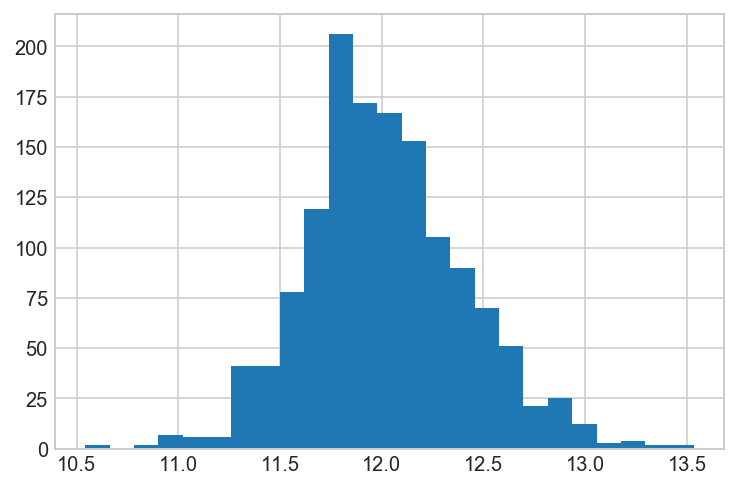

In [6]:
# Looking at the logscale of the SalePrice
plt.hist(np.log(house.SalePrice), bins = 25)

In [7]:
house['lnSalePrice'] = np.log(house.SalePrice)
house.lnSalePrice.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: lnSalePrice, dtype: float64

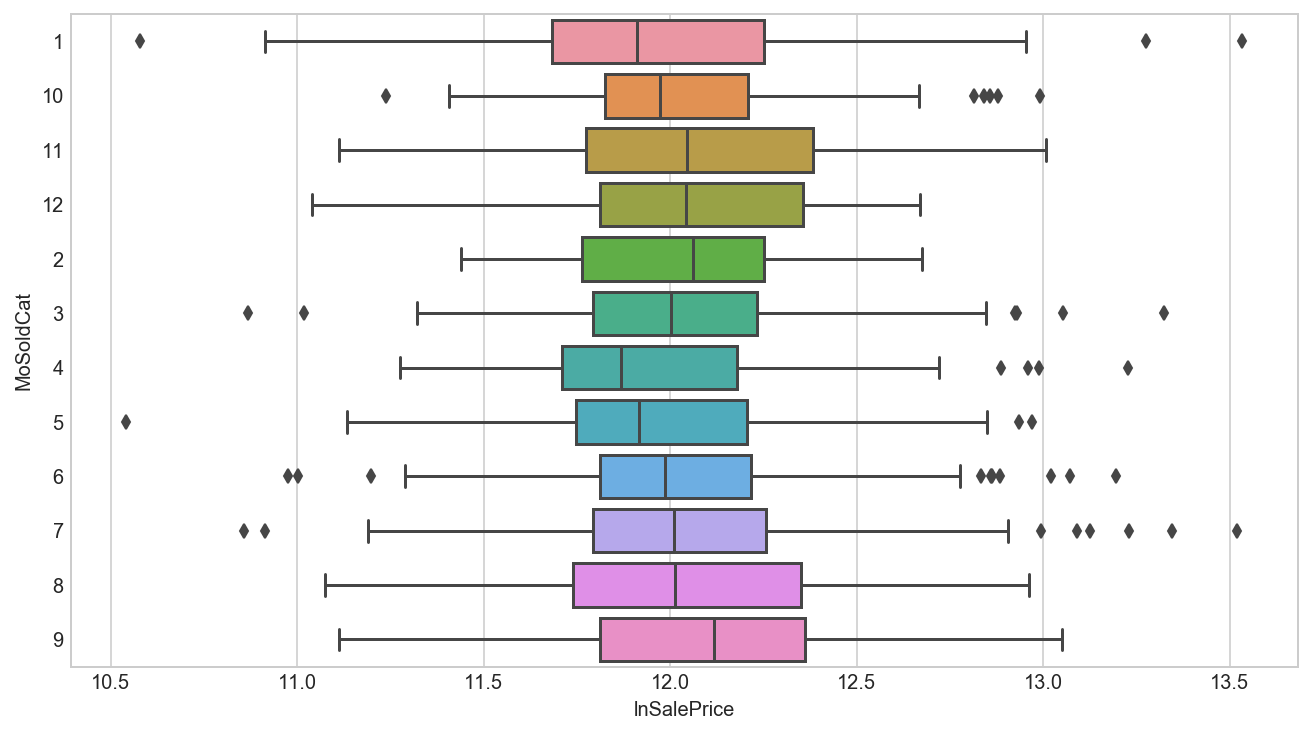

In [8]:
# The log sale price by month.
house['MoSoldCat'] = house.MoSold.map(lambda x: str(x))
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lnSalePrice', y='MoSoldCat', data=house, orient='h', ax=ax)
plt.show()

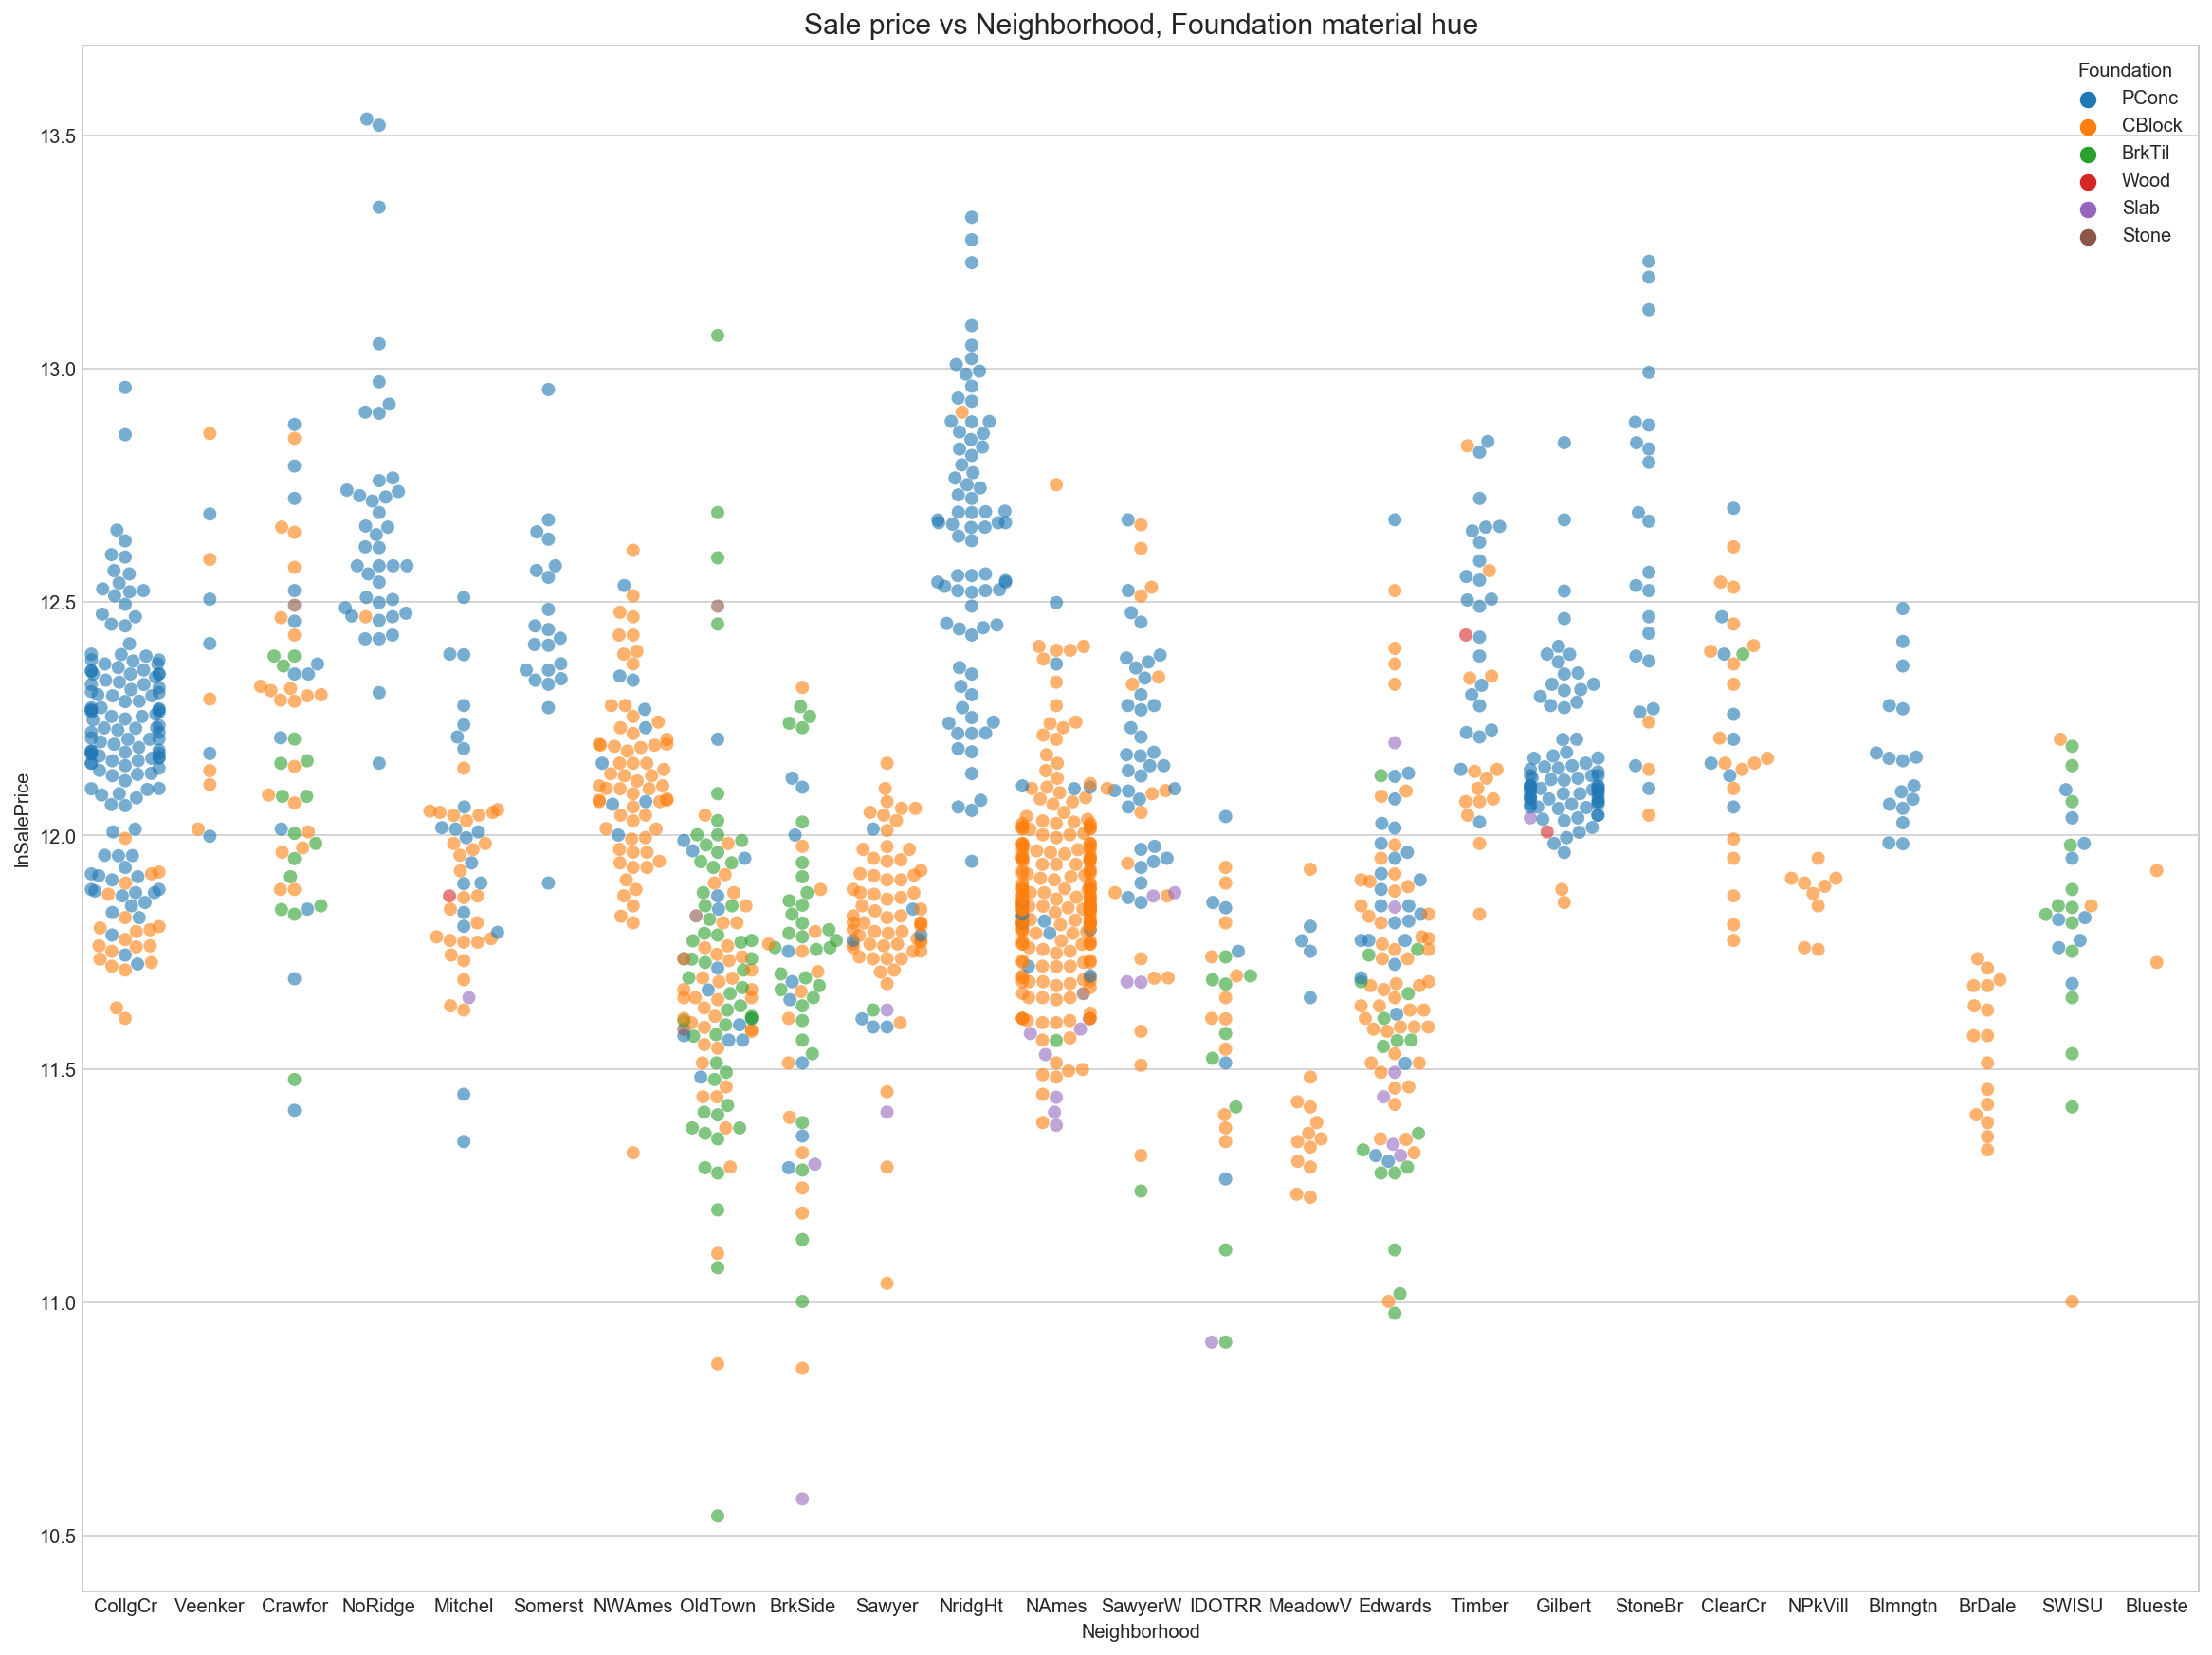

In [9]:
plt.figure(figsize=(20,15))
sns.swarmplot(x="Neighborhood", y="lnSalePrice", hue="Foundation", data=house, alpha=0.6,size =7)
plt.title('Sale price vs Neighborhood, Foundation material hue', fontdict = {'fontsize':15} );

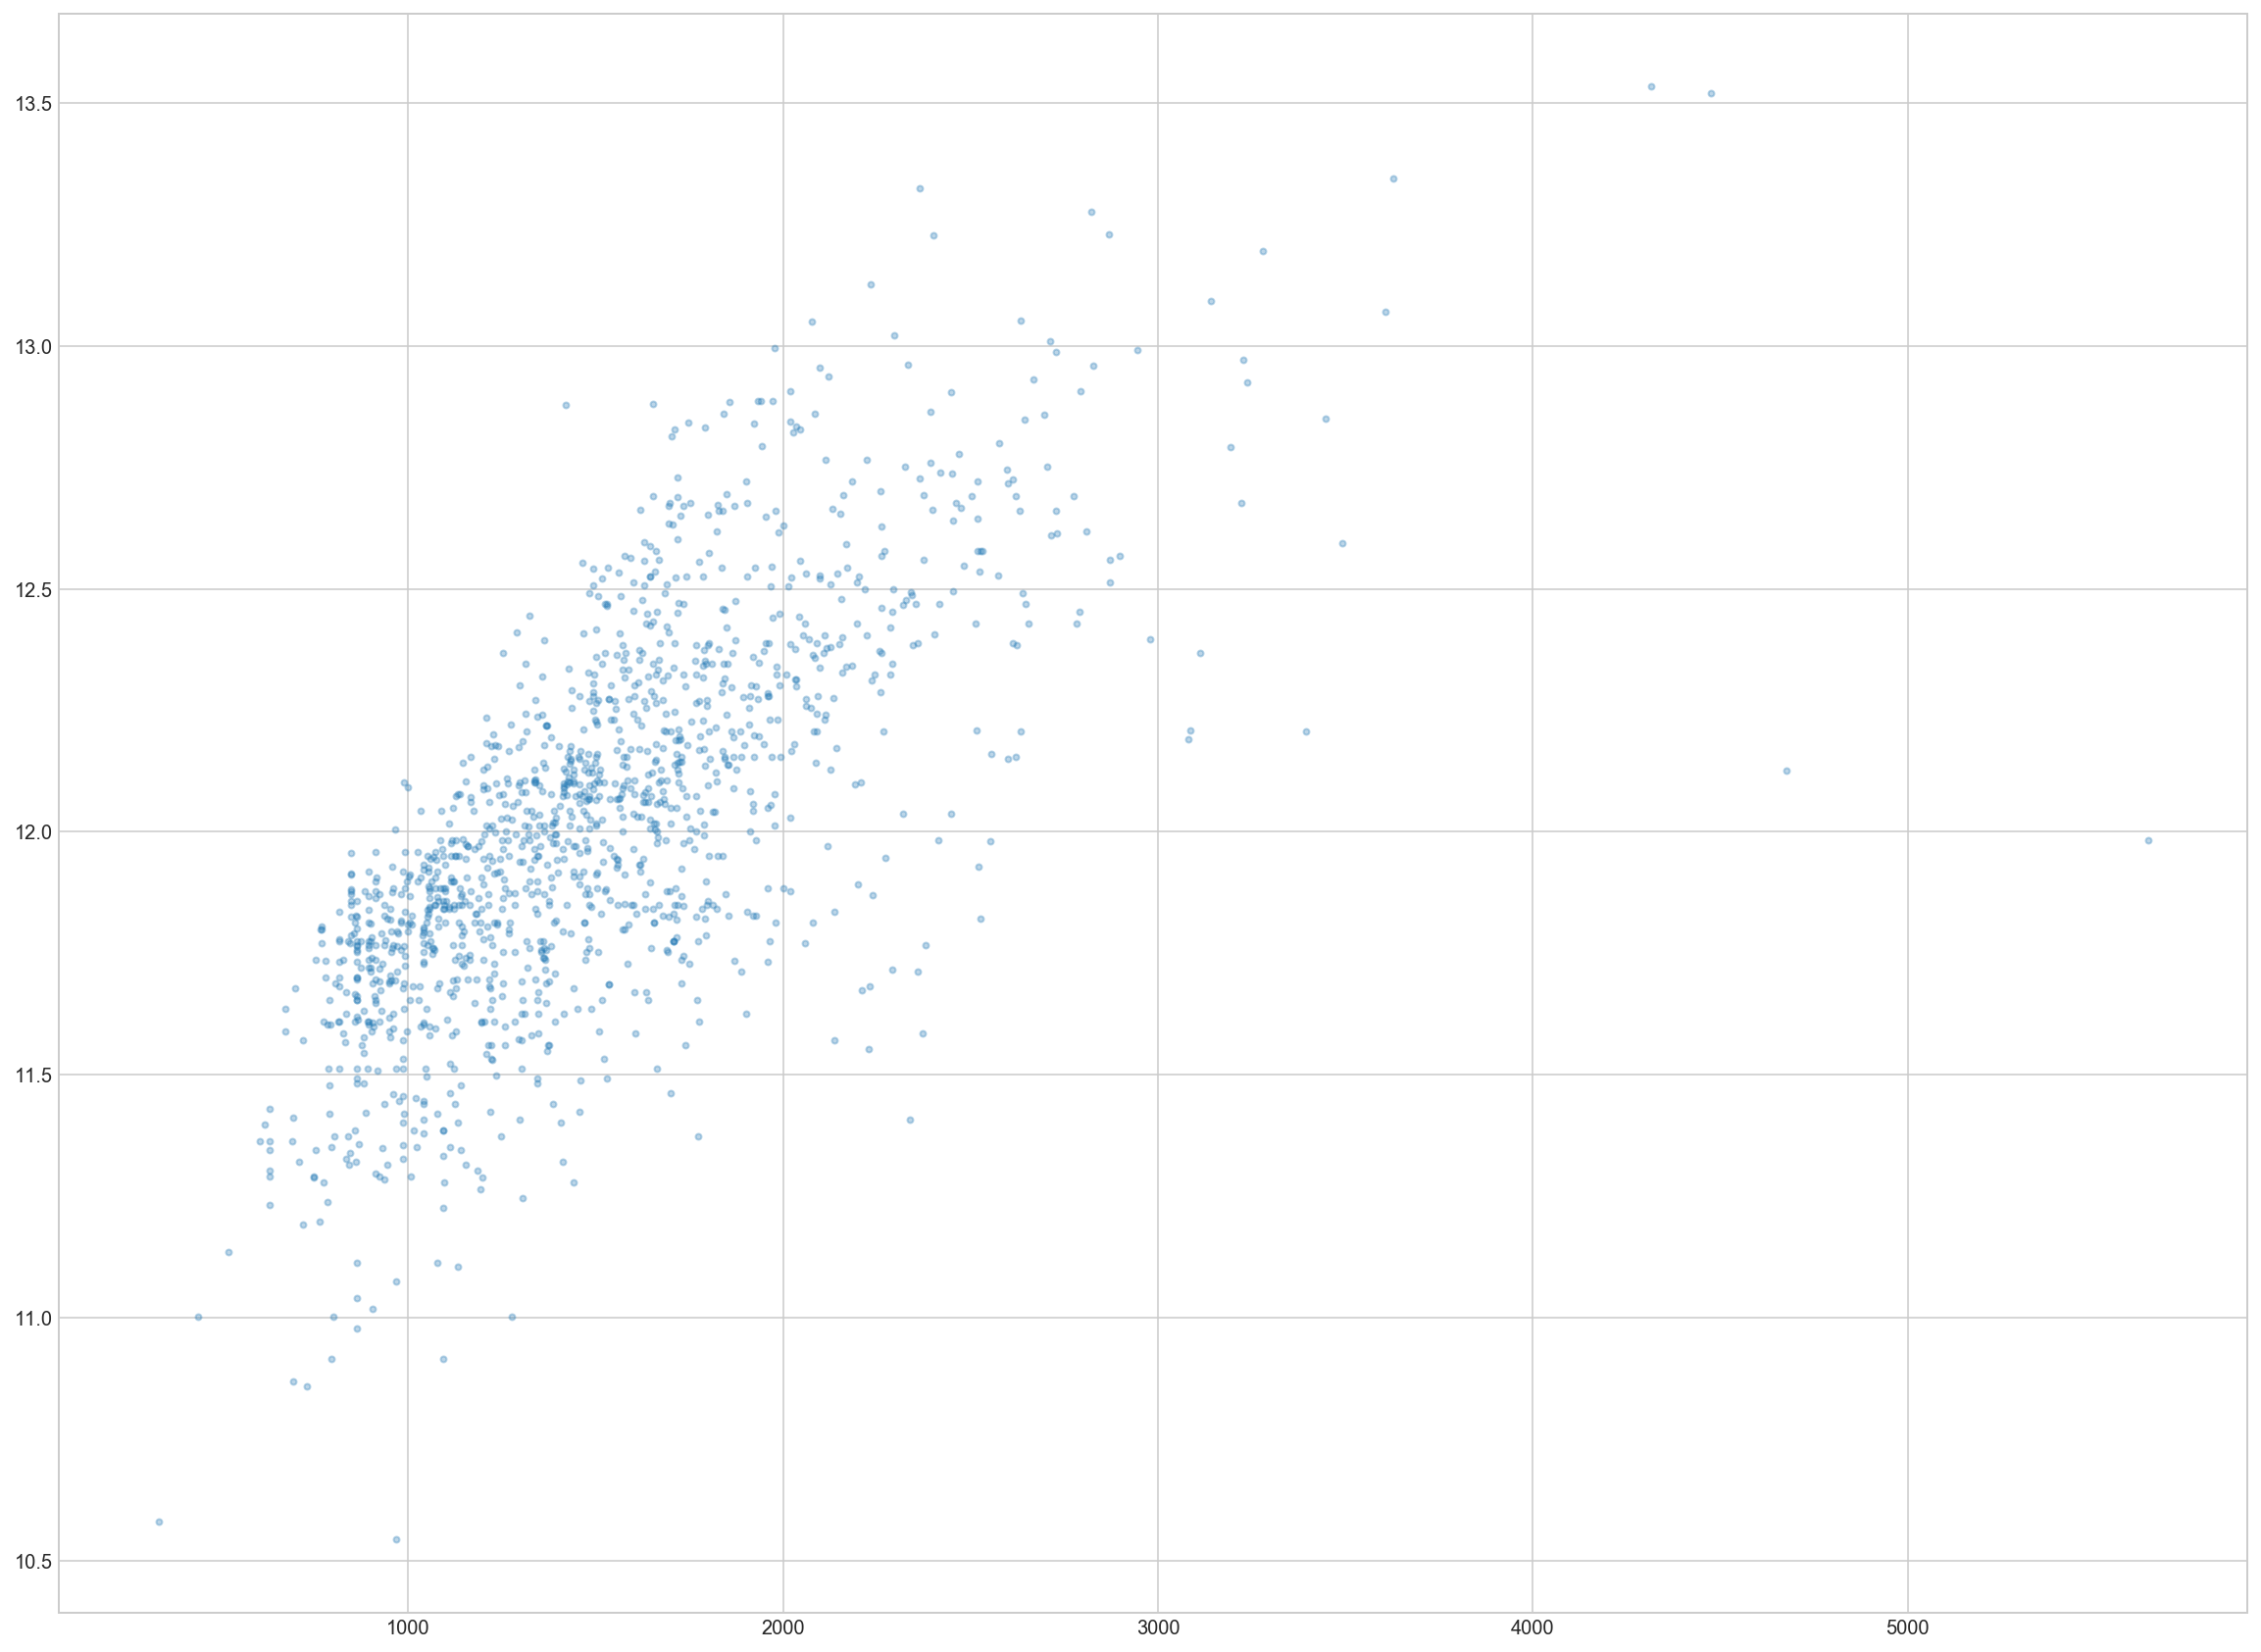

In [10]:
# Size of house is correlated to SalePrice but there is a couple of outliers.
plt.figure(figsize=(20,15))
plt.plot(house.GrLivArea, house.lnSalePrice, '.', alpha=0.3);

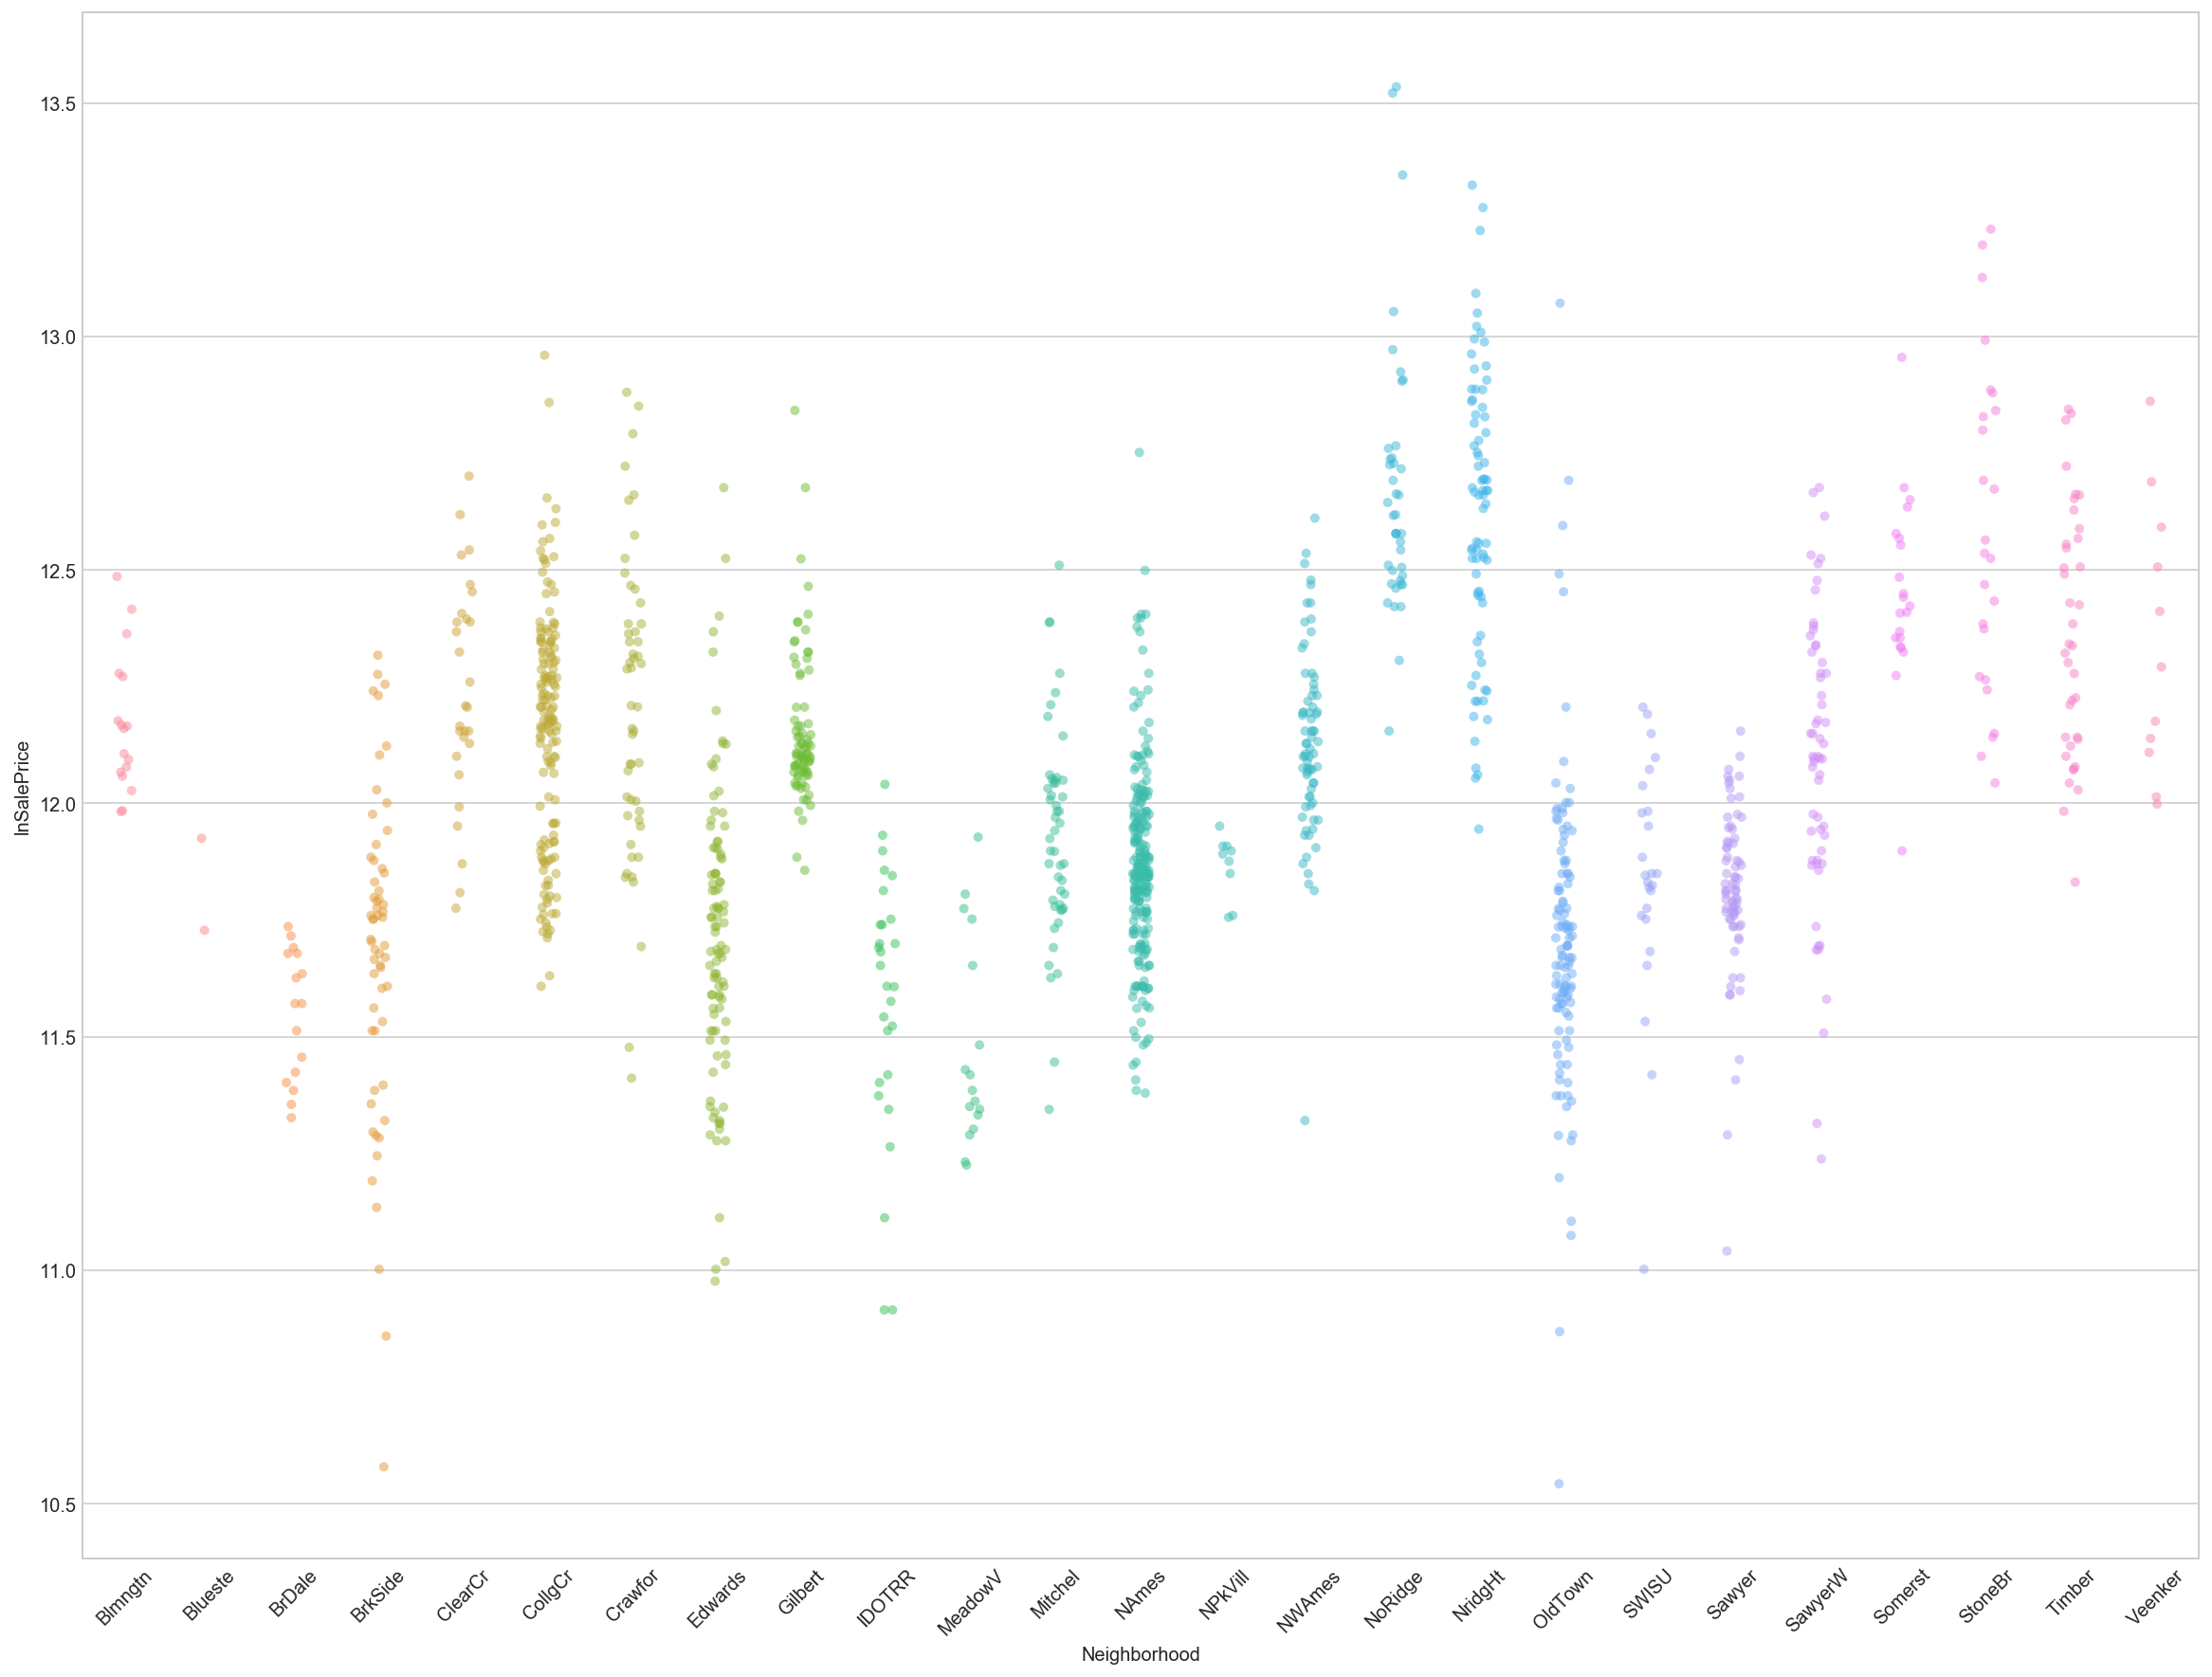

In [11]:
# Looking at the SalePrice relative to Neighborhood.
# Some Neighborhoods tend to command higher prices.
plt.figure(figsize=(20,15))
sns.stripplot(x=house.Neighborhood, y=house.lnSalePrice, 
             order=np.sort(house.Neighborhood.unique()), 
                           jitter=0.1, alpha=0.5)
plt.xticks(rotation=45);



In [12]:
# Find out which variables have null values.
nulls = house.isnull().sum()[house.isnull().sum() > 0]
nulls

LotFrontage      251
Alley           1320
MasVnrType         5
MasVnrArea         5
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      641
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1378
Fence           1108
MiscFeature     1333
dtype: int64

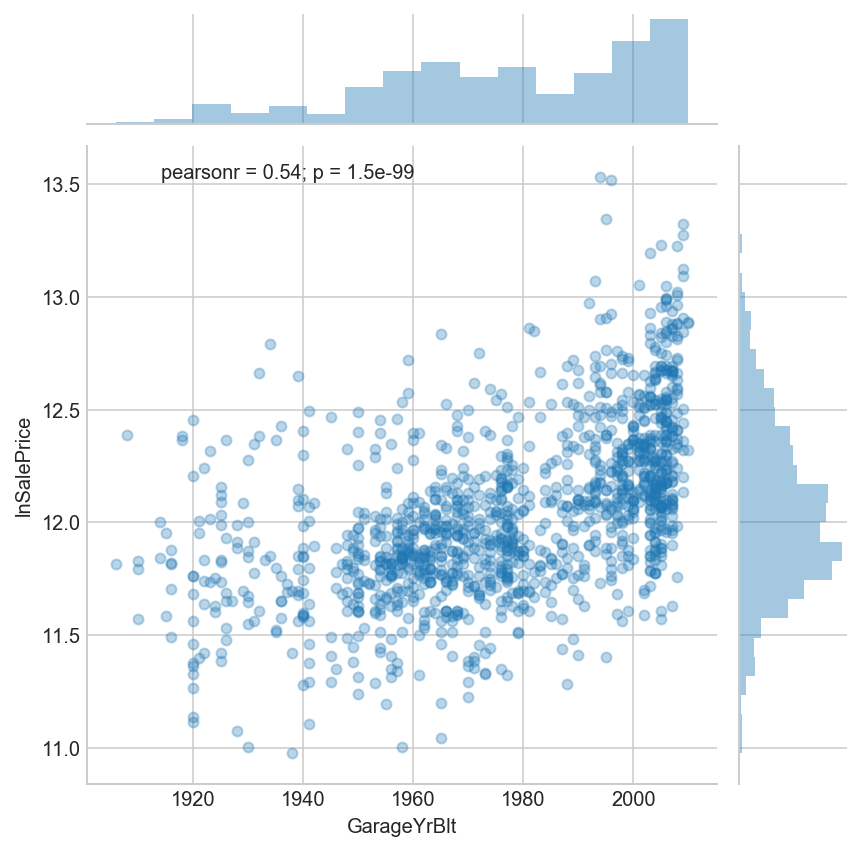

In [13]:
# Looking at GarageYrBlt association with Price
sns.jointplot(house.GarageYrBlt, house.lnSalePrice, joint_kws=dict(s=25, alpha=0.3));

In [14]:
# Function to detect features that don't have any variance.
def proportion_majority(df, col):
    max_count = df[col].value_counts().max()
    return float(max_count)/df.shape[0]

In [15]:
# Columns where the proportion of the majority class is greater than 95%
# If a feature is the same value for more than 95% of observations, drop it.
props = [[col,proportion_majority(house, col)] for col in house.columns]
props = pd.DataFrame(props, columns=['feature','majority'])
props = props[props.majority > 0.95]
props

feature  majority
5         Street  0.997112
9      Utilities  0.999278
14    Condition2  0.989892
22      RoofMatl  0.981227
39       Heating  0.977617
45  LowQualFinSF  0.984116
52  KitchenAbvGr  0.951625
69     3SsnPorch  0.982671
71      PoolArea  0.994946
75       MiscVal  0.963899

In [16]:
# Dropping Electrical, PoolQC, Id and GarageYrBlt. The first two have no variance thus are useless variables. 
# The Id is just an identifier of the house. And it's impossible to estimate the year the garage was built. 
# The rest are features without variance. 
features_to_drop = ['Id', 'Electrical', 'PoolQC', 'GarageYrBlt']
features_no_var = [features for features in props.feature]
house = house.drop(features_to_drop, axis=1)
house = house.drop(features_no_var, axis=1)

In [17]:
# Find out which variables remain that have null values.
nulls = house.isnull().sum()[house.isnull().sum() > 0]
nulls

LotFrontage      251
Alley           1320
MasVnrType         5
MasVnrArea         5
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      641
GarageType        79
GarageFinish      79
GarageQual        79
GarageCond        79
Fence           1108
MiscFeature     1333
dtype: int64

#### Handling missing null values

In [18]:
# Function to fill in missing null values in categorical and continuous variables.
def fill_na(df):
    # Fill missing values on categorical variables with 'None'
    for column in df.select_dtypes('object').columns :
        df[column] = df[column].fillna('None')
    
    # Fill in missing values on continuous variables with 0.
    for column in df.select_dtypes(exclude=['object']):
        df[column] = df[column].fillna(0.)

In [19]:
# Categorical variables will be filled with 'None', and Continuous variables will be filled with 0.
fill_na(house)

In [20]:
# Check any null values left.
nulls = house.isnull().sum()[house.isnull().sum() > 0]
nulls

Series([], dtype: int64)

In [21]:
# Calculate the age of the house when sold
house['YrAgeWhenSold'] = (house.YrSold + (house.MoSold-1)/12.) - house.YearBuilt
house.YrAgeWhenSold

0        5.083333
1       31.333333
2        7.666667
3       91.083333
4        8.916667
5       16.750000
6        3.583333
7       36.833333
8       77.250000
9       69.000000
10      43.083333
11       1.500000
12      46.666667
13       1.583333
14      48.333333
15      78.500000
16      40.166667
17      39.750000
18       4.416667
19      51.333333
20       1.833333
21      77.416667
22       6.666667
23      31.416667
24      42.333333
25       2.500000
26      59.333333
27       3.333333
28      49.916667
29      81.333333
          ...    
1428    70.083333
1429    26.250000
1430     1.500000
1431    33.750000
1432    80.583333
1433     8.333333
1434    29.333333
1435    46.500000
1436    36.333333
1437     0.833333
1438    53.250000
1439    28.833333
1440    86.666667
1441     4.333333
1443    93.333333
1444     3.833333
1445    41.333333
1446    48.250000
1447    12.916667
1448    97.333333
1449    36.583333
1450    35.666667
1451     1.333333
1452     1.333333
1453     0

#### Features Correlation with SalePrice

In [22]:
corr = house.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
corr_with_saleprice = corr.SalePrice
display(corr_with_saleprice)

SalePrice        1.000000
lnSalePrice      0.951422
OverallQual      0.790986
GrLivArea        0.708499
GarageCars       0.640954
GarageArea       0.629048
TotalBsmtSF      0.617536
1stFlrSF         0.617059
FullBath         0.557077
TotRmsAbvGrd     0.536250
YearBuilt        0.517466
MasVnrArea       0.508017
YearRemodAdd     0.499208
Fireplaces       0.471702
BsmtFinSF1       0.394510
WoodDeckSF       0.325670
OpenPorchSF      0.324483
2ndFlrSF         0.318834
HalfBath         0.283088
LotArea          0.270955
BsmtFullBath     0.229134
BsmtUnfSF        0.212858
LotFrontage      0.207389
BedroomAbvGr     0.163267
ScreenPorch      0.116110
MoSold           0.046867
BsmtFinSF2      -0.008722
BsmtHalfBath    -0.013147
YrSold          -0.032322
OverallCond     -0.081196
MSSubClass      -0.085592
EnclosedPorch   -0.115892
YrAgeWhenSold   -0.517850
Name: SalePrice, dtype: float64

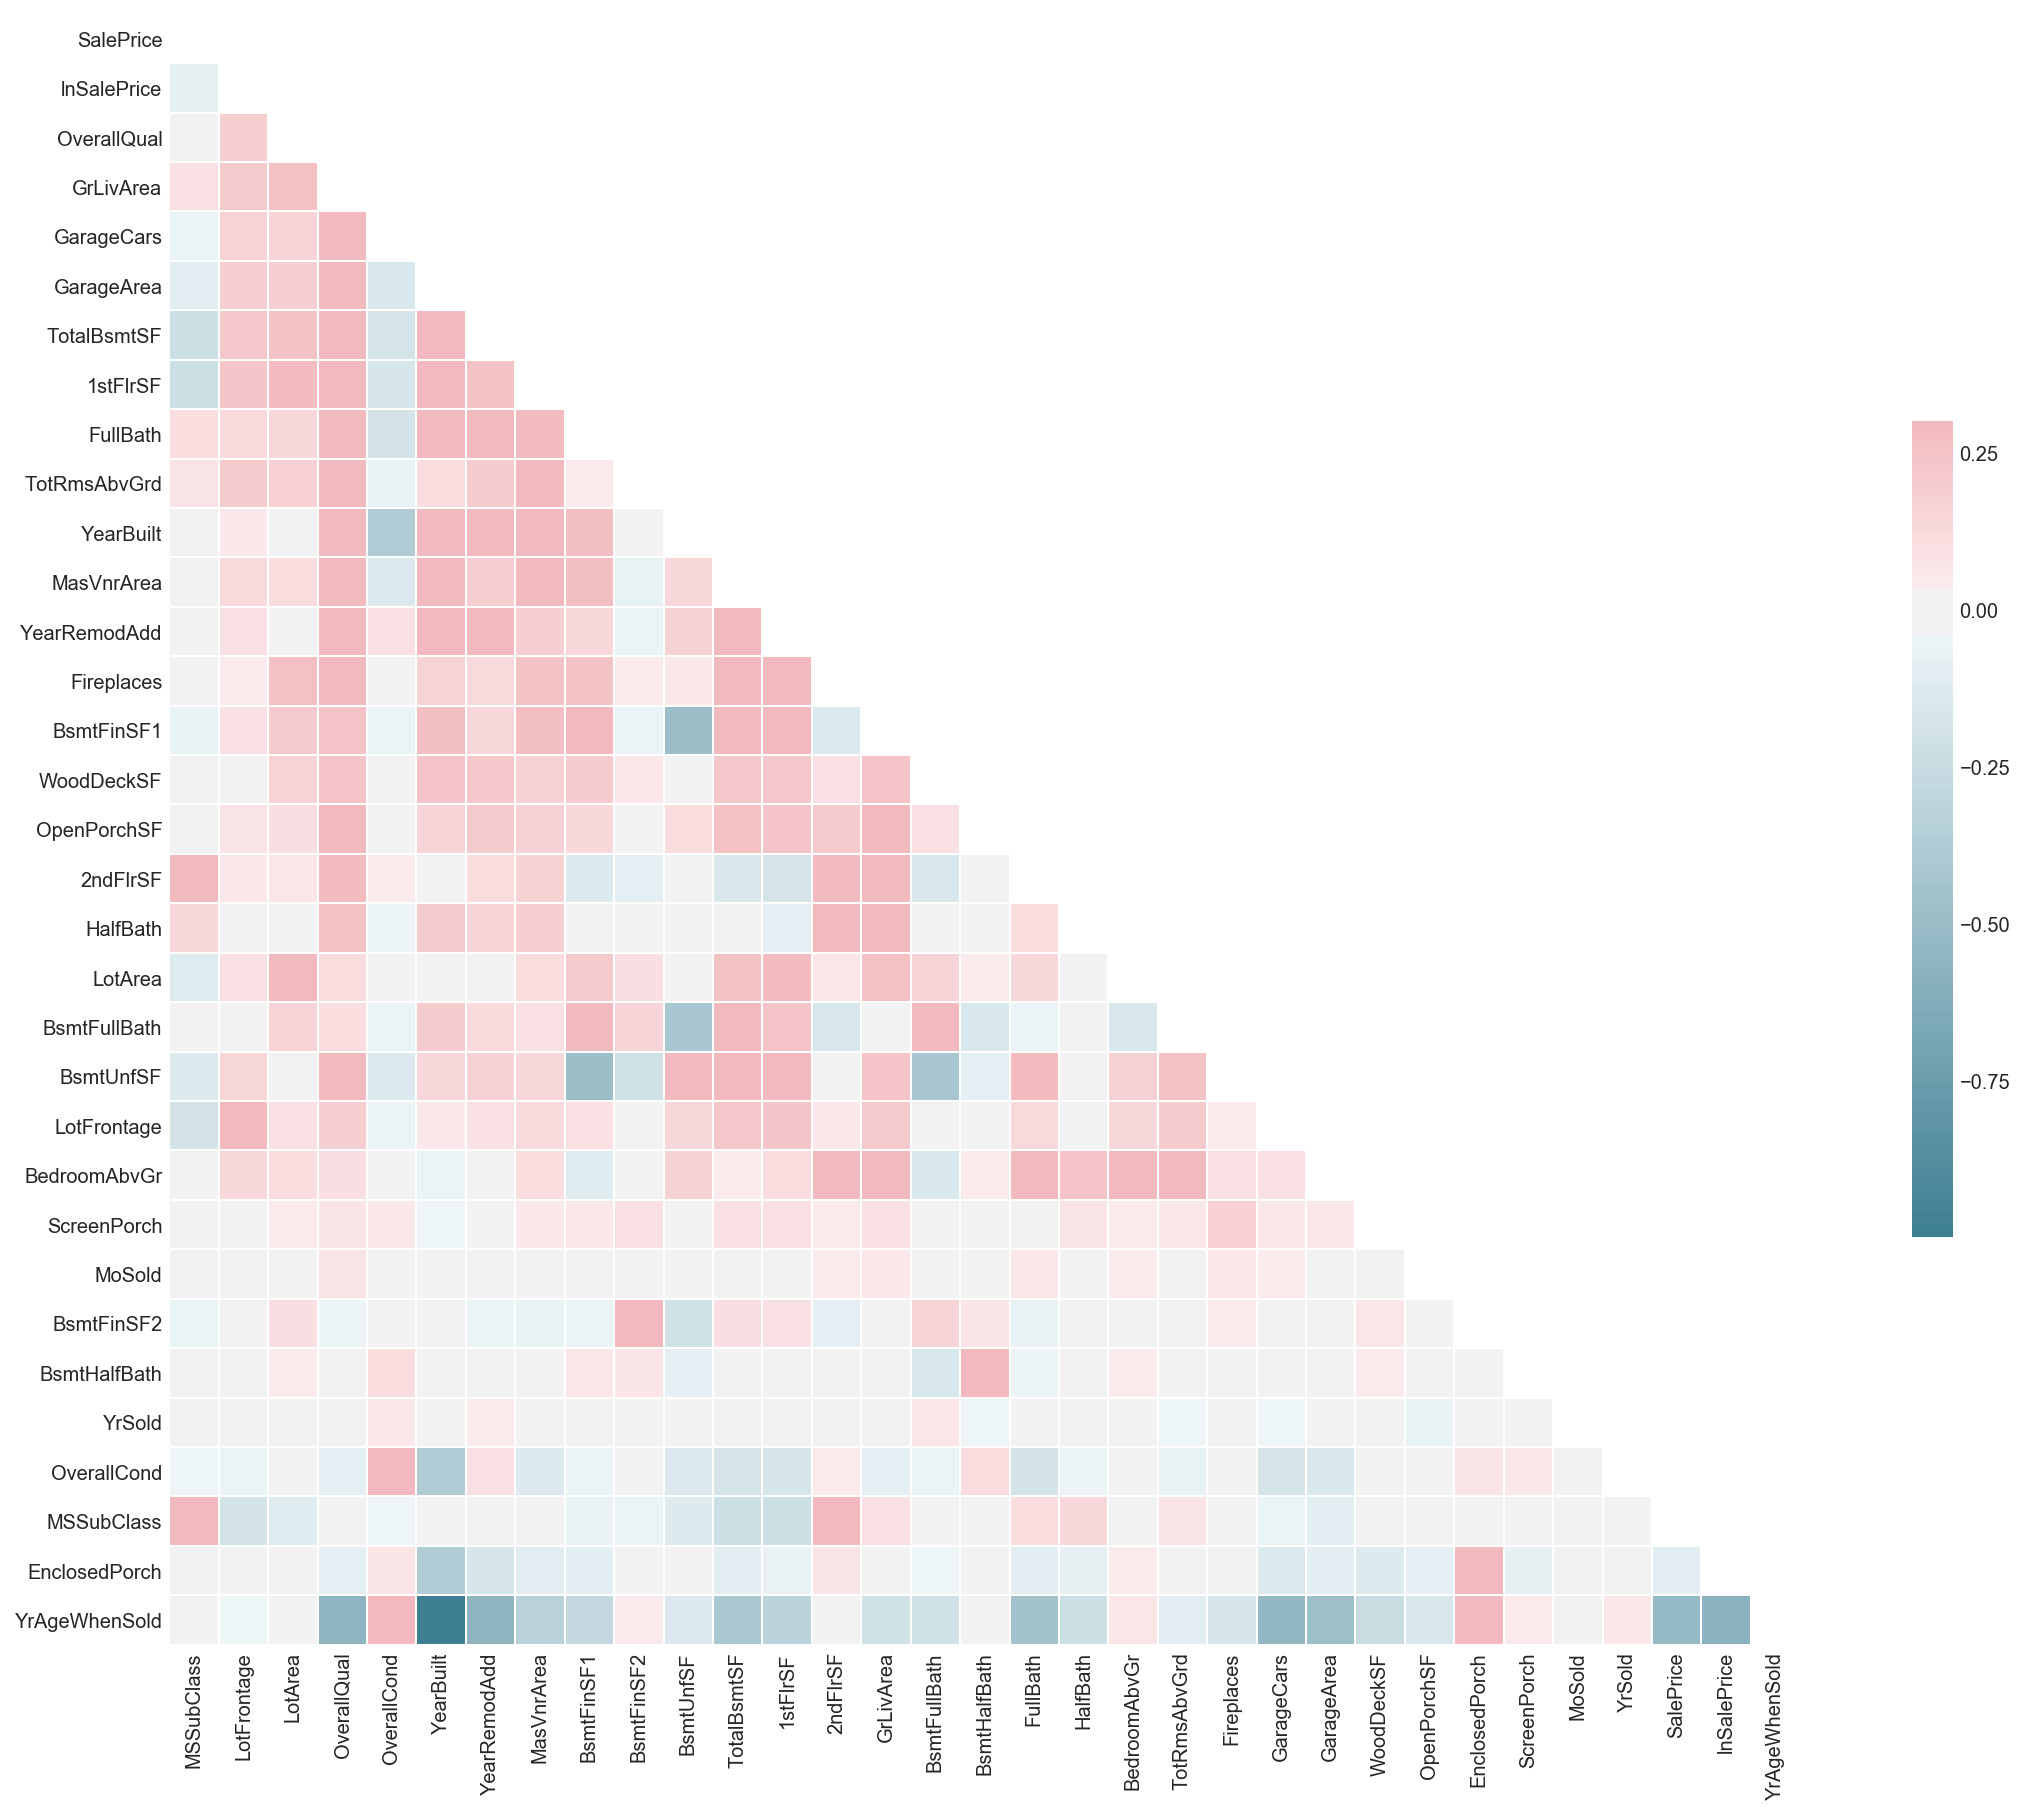

In [23]:
# Plot the correlation matrix

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#### Unfixed features

In [24]:
# these need to be renamed for patsy
house.rename(columns={'2ndFlrSF':'SecondFlrSF', '1stFlrSF':'FirstFlrSF'}, inplace=True)

#### Fixed features

In [25]:
# make a formula for patsy predicting log sale price from the fixed features. 
# years and months are encoded as categorical variables.
fixed = '''
lnSalePrice ~ MSZoning + LotFrontage + LotArea + LotShape + LandContour + LotConfig + 
LandSlope + Neighborhood + Condition1 + BldgType + HouseStyle + 
YearBuilt + MasVnrType + MasVnrArea + Foundation + 
BsmtExposure + BsmtFinType1 + BsmtUnfSF + FirstFlrSF + SecondFlrSF + 
GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + 
TotRmsAbvGrd + Fireplaces + GarageType + SaleCondition + SaleType +
GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + 
EnclosedPorch + ScreenPorch + Fence + C(YrSold) + C(MoSold) + YrAgeWhenSold + BsmtFinSF1 + BsmtFinSF2 -1
'''

import patsy

# Make the X, y from formula
y, X = patsy.dmatrices(fixed, data=house, return_type='dataframe')
y = y.values.ravel()

print y.shape, X.shape

(1385,) (1385, 138)


In [26]:
# Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
test_year = (house.YrSold == 2010)

#### Standardization of X

In [27]:
# Standardize X before splitting
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X) # a numpy.ndarray

#### Manually make training and testing set 

In [28]:
# make training and testing set (test is 2010)
X_train, X_test = Xs[~test_year], Xs[test_year]
y_train, y_test = y[~test_year], y[test_year]

In [29]:
# Convert X_train, X_test into dataframes
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

### LassoCV, _optimal__alpha, Lasso.

In [30]:
from sklearn.linear_model import LassoCV, Lasso

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print "Optimal_Alpha: ", optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................../Users/matt_dynasty/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
........................................................................................................................................................................................................................................................................................................................................

Optimal_Alpha:  0.004155211299182682


In [31]:
optimal_lasso = Lasso(alpha=optimal_lasso.alpha_)
optimal_lasso.fit(X_train, y_train)

print "Optimal Lasso Score", optimal_lasso.score(X_test, y_test)
print "This means the model fed with these features can explain 89% of the variance in SalePrice."

Optimal Lasso Score 0.8908020704348595
This means the model fed with these features can explain 89% of the variance in SalePrice.


In [32]:
lasso_df = pd.DataFrame({'features':X.columns,
                            'coef':optimal_lasso.coef_,
                            'abs_coef':np.abs(optimal_lasso.coef_)})

lasso_df.sort_values('abs_coef', inplace=True, ascending=False)

lasso_df

abs_coef      coef                  features
121  0.129338  0.129338                 GrLivArea
129  0.058606  0.058606                GarageCars
30   0.046007  0.046007   Neighborhood[T.NridgHt]
135  0.032912 -0.032912             YrAgeWhenSold
116  0.032573  0.032573                 YearBuilt
20   0.030093  0.030093   Neighborhood[T.Crawfor]
128  0.028447  0.028447                Fireplaces
36   0.027041  0.027041   Neighborhood[T.StoneBr]
73   0.020279 -0.020279      BsmtFinType1[T.None]
21   0.019911 -0.019911   Neighborhood[T.Edwards]
122  0.018895  0.018895              BsmtFullBath
71   0.018866  0.018866       BsmtFinType1[T.GLQ]
124  0.018620  0.018620                  FullBath
119  0.017905  0.017905                FirstFlrSF
48   0.017650 -0.017650        BldgType[T.Duplex]
134  0.017407  0.017407               ScreenPorch
131  0.017222  0.017222                WoodDeckSF
66   0.016826  0.016826        BsmtExposure[T.Gd]
62   0.016743  0.016743       Foundation[T.PConc]
29   0.016714  0.016714   Neighborhood[T.NoRidge]
49   0.014551 -0.014551         BldgType[T.Twnhs]
24   0.014368 -0.014368   Neighborhood[T.MeadowV]
85   0.014290  0.014290   SaleCondition[T.Normal]
35   0.013706  0.013706   Neighborhood[T.Somerst]
76   0.013152  0.013152      GarageType[T.Attchd]
40   0.013146  0.013146        Condition1[T.Norm]
92   0.013122  0.013122           SaleType[T.New]
50   0.012496 -0.012496        BldgType[T.TwnhsE]
115  0.011828  0.011828                   LotArea
1    0.010554  0.010554              MSZoning[RL]
..        ...       ...                       ...
18   0.000000  0.000000   Neighborhood[T.ClearCr]
15   0.000000 -0.000000   Neighborhood[T.Blueste]
13   0.000000 -0.000000          LandSlope[T.Mod]
12   0.000000 -0.000000       LotConfig[T.Inside]
11   0.000000 -0.000000          LotConfig[T.FR3]
7    0.000000  0.000000        LandContour[T.Low]
5    0.000000 -0.000000           LotShape[T.Reg]
52   0.000000  0.000000      HouseStyle[T.1Story]
53   0.000000 -0.000000      HouseStyle[T.2.5Fin]
56   0.000000  0.000000      HouseStyle[T.SFoyer]
74   0.000000 -0.000000       BsmtFinType1[T.Rec]
89   0.000000  0.000000         SaleType[T.ConLD]
87   0.000000  0.000000           SaleType[T.CWD]
84   0.000000 -0.000000   SaleCondition[T.Family]
83   0.000000  0.000000   SaleCondition[T.Alloca]
82   0.000000  0.000000  SaleCondition[T.AdjLand]
80   0.000000 -0.000000      GarageType[T.Detchd]
78   0.000000  0.000000     GarageType[T.BuiltIn]
77   0.000000 -0.000000     GarageType[T.Basment]
72   0.000000 -0.000000       BsmtFinType1[T.LwQ]
57   0.000000 -0.000000        HouseStyle[T.SLvl]
70   0.000000 -0.000000       BsmtFinType1[T.BLQ]
67   0.000000 -0.000000        BsmtExposure[T.Mn]
65   0.000000 -0.000000        Foundation[T.Wood]
64   0.000000  0.000000       Foundation[T.Stone]
61   0.000000 -0.000000      Foundation[T.CBlock]
60   0.000000  0.000000       MasVnrType[T.Stone]
59   0.000000 -0.000000        MasVnrType[T.None]
58   0.000000  0.000000     MasVnrType[T.BrkFace]
137  0.000000  0.000000                BsmtFinSF2

[138 rows x 3 columns]

In [35]:
type(y_test)

numpy.ndarray

In [39]:
y_pred_df = pd.DataFrame(optimal_lasso.predict(X_test), columns=['pred_y']).reset_index(drop=True)
y_test_df = pd.DataFrame({'y_test':y_test})

result = pd.concat([y_test_df, y_pred_df ], axis=1)
result.head()

y_test     pred_y
0  11.911702  11.915215
1  11.944708  11.889202
2  11.811547  11.770608
3  12.631340  12.573117
4  12.016726  12.048000

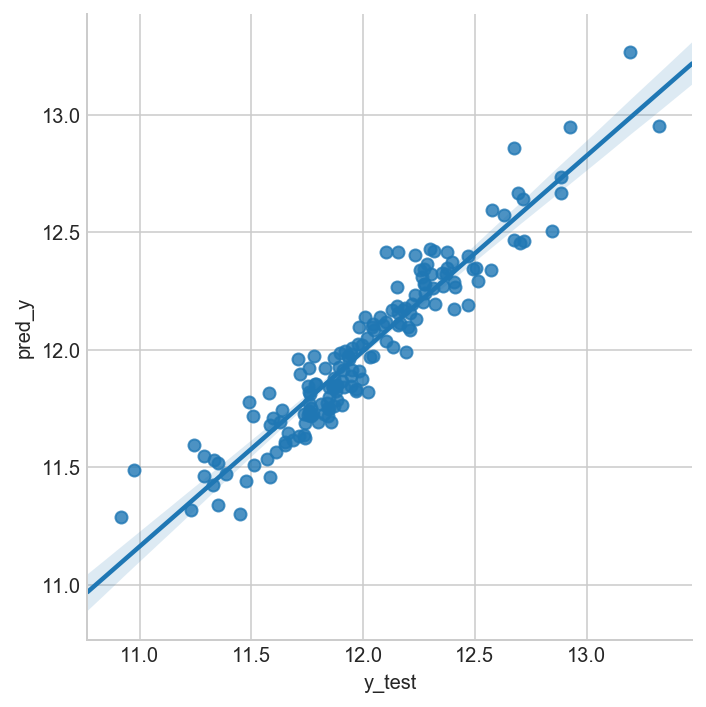

In [55]:
# Show the results of a linear regression plot.
sns.lmplot(x="y_test", y="pred_y", data=result);

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [94]:
renovatable = ['RoofStyle', 'Exterior1st', 'Exterior2nd',
              'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 
               'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
               'KitchenQual', 'GarageType', 'GarageFinish',
              'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
              'PavedDrive']

renovatable_f = '~ '+' + '.join(renovatable)+' -1'

# make the renovation predictor matrix
Xren = patsy.dmatrix(renovatable_f, data=house, return_type='dataframe')
print Xren.shape

(1385, 91)


#### Standardization

In [95]:
ss = StandardScaler()
Xrens = ss.fit_transform(Xren)

In [96]:
# split by year again
Xren_train, Xren_test = Xrens[~test_year], Xrens[test_year]

Lasso selects the only some feature while reduces the coefficients of others to zero. This property is known as feature selection and which is absent in case of ridge. We are looking to mitigate multicollinearity, not feature elimination and keeping all the renovatables in.

In [97]:
# get out the residuals for training and testing, in terms of dollars.
train_resids = np.exp(y_train) - np.exp(optimal_lasso.predict(X_train))
test_resids = np.exp(y_test) - np.exp(optimal_lasso.predict(X_test))

In [98]:
# checking for outliers
print "Min. Train Residuals: ", train_resids.min()
print "50th percentile: ", stats.scoreatpercentile(train_resids, 0.5)

Min. Train Residuals:  -602251.3551694809
50th percentile:  -67074.43023883167


In [99]:
# truncate the minimum at -70000:
train_resids[train_resids < -70000] = -70000

In [100]:
from sklearn.linear_model import RidgeCV

In [101]:
ren_cv = RidgeCV(alphas=np.logspace(-5,4,300), cv=10)
ren_cv.fit(Xren_train, train_resids)

RidgeCV(alphas=array([1.00000e-05, 1.07177e-05, ..., 9.33039e+03, 1.00000e+04]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [102]:
print "Alpha: ", ren_cv.alpha_

Alpha:  51.56732244854963


In [103]:
print "Train Score: ", ren_cv.score(Xren_train, train_resids)

Train Score:  0.2408717898162035


Our model generalized pretty well for in-sample at 24% variance.

In [104]:
print "Test Score: ", ren_cv.score(Xren_test, test_resids)

Test Score:  0.20970123912423966


Our model generalized fairly well out of sample at 20% variance.

#### Taking a look at the renovatable coefficients

In [105]:
renovatable_coefs = pd.DataFrame(dict(coef=ren_cv.coef_,
                                     abscoef=np.abs(ren_cv.coef_),
                                     feature=Xren.columns))
renovatable_coefs.sort_values('abscoef', ascending=False, inplace=True)
renovatable_coefs.head(25)

abscoef          coef                 feature
67  10465.990379 -10465.990379       KitchenQual[T.TA]
66   7867.760288  -7867.760288       KitchenQual[T.Gd]
40   6987.662127  -6987.662127         ExterQual[T.TA]
81   4873.598163  -4873.598163        GarageQual[T.TA]
39   4619.557910  -4619.557910         ExterQual[T.Gd]
8    3892.836611   3892.836611  Exterior1st[T.BrkFace]
77   3761.582945  -3761.582945        GarageQual[T.Fa]
65   3472.608617  -3472.608617       KitchenQual[T.Fa]
72   3181.033076   3181.033076    GarageType[T.Detchd]
44   2820.743094  -2820.743094         ExterCond[T.TA]
89   2173.553990  -2173.553990              GarageCars
64   2171.466479  -2171.466479         HeatingQC[T.TA]
55   2061.400786  -2061.400786     BsmtFinType2[T.BLQ]
60   1901.869639  -1901.869639     BsmtFinType2[T.Unf]
33   1827.013651   1827.013651  Exterior2nd[T.Wd Sdng]
48   1783.522853   1783.522853          BsmtCond[T.TA]
59   1755.592904  -1755.592904     BsmtFinType2[T.Rec]
57   1708.099426  -1708.099426     BsmtFinType2[T.LwQ]
42   1681.527358  -1681.527358         ExterCond[T.Gd]
45   1589.731594   1589.731594          BsmtCond[T.Gd]
68   1586.077747   1586.077747    GarageType[T.Attchd]
30   1564.546381  -1564.546381    Exterior2nd[T.Stone]
90   1530.671128   1530.671128              GarageArea
38   1483.367468  -1483.367468         ExterQual[T.Fa]
4    1454.472218   1454.472218      RoofStyle[Mansard]

We are predicting the dollar amount right now in terms of ERRORS of the first model.
So for example, if the first model overestimated the price for a house, then the error in price (residual) would be negative.  We are predicting those residuals. Positive and negative means the same thing.